# **Proyek Sistem Rekomendasi Buku**

## Import Libraries

In [1]:
# Import library dasar
import pandas as pd
import numpy as np

# Import library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Import library untuk machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Import library untuk interaktivitas di notebook
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

# Mengabai peringatan yang tidak penting
import warnings
warnings.filterwarnings("ignore")

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


## Data Loading

In [2]:
# Memuat dataset dari file CSV
try:
    books = pd.read_csv('./datasets/Books.csv', on_bad_lines='skip', encoding='latin-1', low_memory=False)
    ratings = pd.read_csv('./datasets/Ratings.csv', on_bad_lines='skip', encoding='latin-1', low_memory=False)
    users = pd.read_csv('./datasets/Users.csv', on_bad_lines='skip', encoding='latin-1', low_memory=False)
    print("Dataset berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: {e}.")
    print("Pastikan file Books.csv, Ratings.csv, dan Users.csv berada di direktori yang sama.")

Dataset berhasil dimuat.


## Data Understanding - Part 1

### Inspeksi Data Awal

In [3]:
# Inspeksi Data Awal (Data Understanding - Part 1)
print("--- Inspeksi DataFrame 'books' ---")
print(books.head())
print("\nInfo 'books':")
books.info()
print("\nCek Missing Values 'books':")
print(books.isnull().sum())
print("\n" + "="*40 + "\n")

print("--- Inspeksi DataFrame 'users' ---")
print(users.head())
print("\nInfo 'users':")
users.info()
print("\nCek Missing Values 'users':")
print(users.isnull().sum())
print("\n" + "="*40 + "\n")

print("--- Inspeksi DataFrame 'ratings' ---")
print(ratings.head())
print("\nInfo 'ratings':")
ratings.info()
print("\nCek Missing Values 'ratings':")
print(ratings.isnull().sum())

--- Inspeksi DataFrame 'books' ---
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0

## Data Preparation - Part 1

### Data Cleaning & Preprocessing

In [4]:
# Data Cleaning & Preprocessing (Data Preparation - Part 1)
print("--- Memulai Data Cleaning ---")

# Membersihkan kolom 'Year-Of-Publication'
# Mengubah ke numerik, error diubah menjadi NaN (Not a Number)
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
# Mengganti tahun yang tidak valid (misal: 0 atau > 2025) dengan NaN
books.loc[(books['Year-Of-Publication'] == 0) | (books['Year-Of-Publication'] > 2025), 'Year-Of-Publication'] = np.NAN
# Mengisi NaN dengan median tahun publikasi
books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].median()), inplace=True)

# Membersihkan kolom 'Publisher' dan 'Book-Author'
# Mengisi NaN dengan 'Unknown'
books['Publisher'].fillna('Unknown', inplace=True)
books['Book-Author'].fillna('Unknown', inplace=True)

# Membersihkan kolom 'Age' di 'users'
# Mengganti umur yang tidak realistis (< 5 atau > 100) dengan NaN
users.loc[(users['Age'] < 5) | (users['Age'] > 100), 'Age'] = np.nan
# Mengisi NaN dengan median umur
users['Age'].fillna(users['Age'].median(), inplace=True)


print("--- Data Cleaning Selesai ---")
print("\nInfo 'books' setelah cleaning:")
books.info()
print("\nInfo 'users' setelah cleaning:")
users.info()

--- Memulai Data Cleaning ---
--- Data Cleaning Selesai ---

Info 'books' setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271360 non-null  object 
 3   Year-Of-Publication  271360 non-null  float64
 4   Publisher            271360 non-null  object 
 5   Image-URL-S          271360 non-null  object 
 6   Image-URL-M          271360 non-null  object 
 7   Image-URL-L          271357 non-null  object 
dtypes: float64(1), object(7)
memory usage: 16.6+ MB

Info 'users' setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID 

## Data Understanding - Part 2

### Exploratory Data Analysis (EDA)

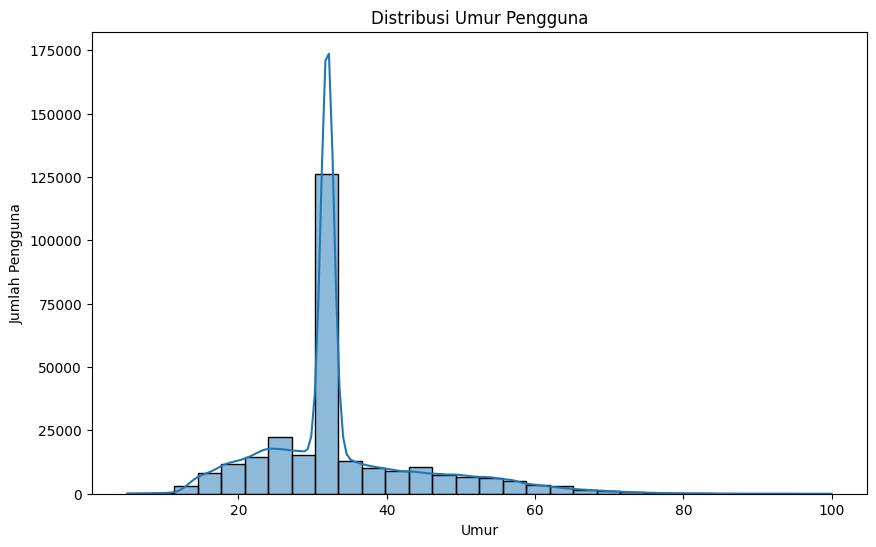

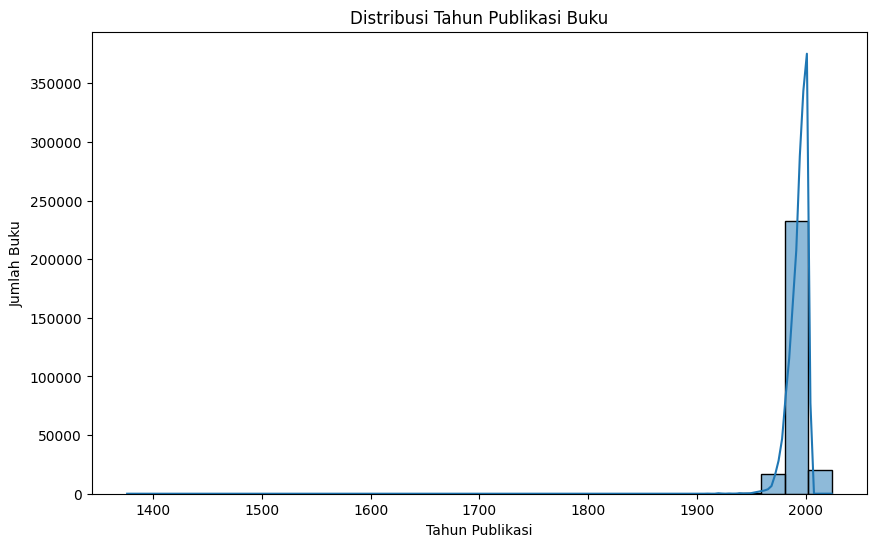

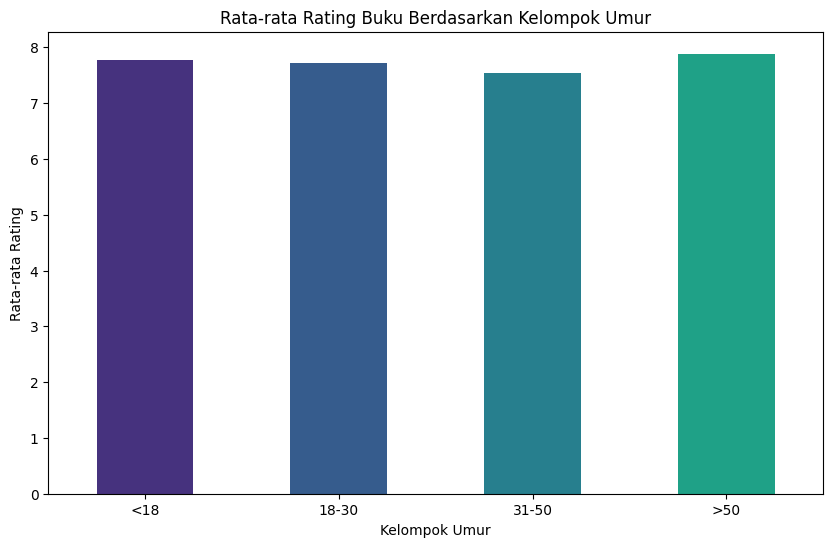

In [5]:
# Exploratory Data Analysis (EDA) - (Data Understanding - Part 2)

# --- Univariate Analysis ---
# 1. Distribusi Umur Pengguna
plt.figure(figsize=(10, 6))
sns.histplot(users['Age'], bins=30, kde=True)
plt.title('Distribusi Umur Pengguna')
plt.xlabel('Umur')
plt.ylabel('Jumlah Pengguna')
plt.show()

# 2. Distribusi Tahun Publikasi Buku
plt.figure(figsize=(10, 6))
sns.histplot(books['Year-Of-Publication'], bins=30, kde=True)
plt.title('Distribusi Tahun Publikasi Buku')
plt.xlabel('Tahun Publikasi')
plt.ylabel('Jumlah Buku')
plt.show()

# --- Bivariate Analysis ---
# Gabungkan semua data untuk analisis mendalam
df_merged = pd.merge(ratings, users, on='User-ID')
df_merged = pd.merge(df_merged, books, on='ISBN')

# 3. Rata-rata Rating berdasarkan Kelompok Umur
# Membuat kategori umur
bins = [0, 18, 30, 50, 100]
labels = ['<18', '18-30', '31-50', '>50']
df_merged['Age-Group'] = pd.cut(df_merged['Age'], bins=bins, labels=labels, right=False)

# Mengabaikan rating 0 (implisit) untuk analisis ini
avg_rating_by_age = df_merged[df_merged['Book-Rating'] != 0].groupby('Age-Group')['Book-Rating'].mean()

plt.figure(figsize=(10, 6))
avg_rating_by_age.plot(kind='bar', color=sns.color_palette('viridis'))
plt.title('Rata-rata Rating Buku Berdasarkan Kelompok Umur')
plt.xlabel('Kelompok Umur')
plt.ylabel('Rata-rata Rating')
plt.xticks(rotation=0)
plt.show()

## Data Preparation - Part 2

### Menggabungkan dan Finalisasi Data

In [6]:
# Menggabungkan dan Finalisasi Data (Data Preparation - Part 2)

# Menggabungkan ratings dan books
df_final = pd.merge(ratings, books, on='ISBN', how='left')

# Menghapus duplikat berdasarkan interaksi user-judul buku
df_final.drop_duplicates(['User-ID', 'Book-Title'], inplace=True)

# Menghapus baris dimana atribut penting untuk model tidak ada
df_final.dropna(subset=['Book-Title', 'Book-Author'], inplace=True)

print(f"Jumlah data setelah digabung dan dibersihkan: {len(df_final)}")

Jumlah data setelah digabung dan dibersihkan: 1026358


## Model Development

### Content-Based Filtering

In [7]:
# Model Development - Content-Based Filtering

# Persiapan data unik buku
books_for_content = df_final.drop_duplicates('Book-Title')[['Book-Title', 'Book-Author']]

# Inisialisasi dan fitting TF-IDF
tf_idf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tf_idf.fit_transform(books_for_content['Book-Author'].fillna(''))

def get_book_recommendations(book_title, k=5):
    try:
        # 1. Cari indeks dari judul buku yang dipilih
        book_index = books_for_content[books_for_content['Book-Title'] == book_title].index[0]

        # 2. Ambil vektor TF-IDF untuk buku tersebut
        book_vector = tfidf_matrix[book_index]

        # 3. Hitung cosine similarity HANYA antara buku itu dan semua buku lainnya (sangat efisien)
        sim_scores = cosine_similarity(book_vector, tfidf_matrix).flatten()

        # 4. Ambil indeks dari k+1 buku paling mirip (k+1 karena buku itu sendiri akan paling mirip)
        top_indices = sim_scores.argsort()[-k-1:][::-1]

        # 5. Hapus indeks buku itu sendiri dari hasil
        top_indices = [i for i in top_indices if i != book_index]

        # 6. Ambil judul buku dari indeks teratas
        recommended_titles = books_for_content['Book-Title'].iloc[top_indices].head(k)
        recommendations = pd.DataFrame({'Book-Title': recommended_titles}).merge(books_for_content)
        
        return recommendations
    except (IndexError, KeyError):
        print(f"Buku dengan judul '{book_title}' tidak ditemukan atau terjadi error.")
        return pd.DataFrame()

# --- Widget Interaktif ---
book_titles_list = books_for_content['Book-Title'].sort_values().tolist()

@interact(
    book_title=widgets.Dropdown(options=book_titles_list, description='Pilih Judul Buku:', layout={'width': '500px'}),
    k=widgets.IntSlider(min=5, max=15, step=1, value=10, description='Jumlah Rekomendasi:')
)
def interactive_recommendations(book_title, k):
    recommendations_df = get_book_recommendations(book_title, k)
    if not recommendations_df.empty:
        display(recommendations_df)

interactive(children=(Dropdown(description='Pilih Judul Buku:', layout=Layout(width='500px'), options=(' A Lig…

### Preparation for Collaborative Filtering

In [8]:
# --- Preparation for Collaborative Filtering ---

# Menggunakan data yang sudah digabungkan dan bersih
df_collab = df_final.copy()

# Konseptual Outlier Handling:
# Untuk model collaborative, kita fokus pada pengguna yang aktif dan buku yang cukup po# Untuk mengurangi noise dan membuat model lebih stabil stabil
user_counts = df_collab['User-ID'].value_counts()
book_counts = df_collab['ISBN'].value_counts()

# Filter pengguna yang memberi rating > 10 buku dan buku yang menerima > 5 rating
df_collab = df_collab[df_collab['User-ID'].isin(user_counts[user_counts > 10].index)]
df_collab = df_collab[df_collab['ISBN'].isin(book_counts[book_counts > 5].index)]

# Fokus pada rating eksplisit (1-10)
df_collab = df_collab[df_collab['Book-Rating'] != 0]

print(f"Jumlah data setelah difilter untuk Collaborative Filtering: {len(df_collab)}")


# Encoding User-ID dan ISBN
user_ids = df_collab['User-ID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

isbn_ids = df_collab['ISBN'].unique().tolist()
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_ids)}
isbn_encoded_to_isbn = {i: x for i, x in enumerate(isbn_ids)}

# Mapping dan Normalisasi
df_collab['user'] = df_collab['User-ID'].map(user_to_user_encoded)
df_collab['book'] = df_collab['ISBN'].map(isbn_to_isbn_encoded)

min_rating = min(df_collab['Book-Rating'])
max_rating = max(df_collab['Book-Rating'])
df_collab['rating'] = df_collab['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi data training dan validasi
df_shuffled = df_collab.sample(frac=1, random_state=42)
x = df_shuffled[['user', 'book']].values
y = df_shuffled['rating'].values

train_indices = int(0.8 * df_shuffled.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

Jumlah data setelah difilter untuk Collaborative Filtering: 168507


### Collaborative Filtering

In [17]:
# Model Development - Collaborative Filtering
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size=6, dropout_rate=0.7, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        
        # User embeddings dengan regularisasi lebih kuat
        self.user_embedding = layers.Embedding(
            num_users, embedding_size, 
            embeddings_initializer='he_normal', 
            embeddings_regularizer=keras.regularizers.l2(1e-2)  # Regularisasi lebih kuat
        )
        self.user_bias = layers.Embedding(
            num_users, 1,
            embeddings_regularizer=keras.regularizers.l2(1e-2)
        )
        
        # Book embeddings dengan regularisasi lebih kuat
        self.book_embedding = layers.Embedding(
            num_books, embedding_size, 
            embeddings_initializer='he_normal', 
            embeddings_regularizer=keras.regularizers.l2(1e-2)  
        )
        self.book_bias = layers.Embedding(
            num_books, 1,
            embeddings_regularizer=keras.regularizers.l2(1e-2)
        )
        
        # Multiple dropout layers
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate * 0.8)  # Dropout bertingkat
        
        # Batch normalization
        self.batch_norm = layers.BatchNormalization()
        
        # Dense layer untuk kompleksitas tambahan dengan regularisasi
        self.dense = layers.Dense(
            embedding_size // 2, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(1e-2),
            bias_regularizer=keras.regularizers.l2(1e-2)
        )
        self.dropout3 = layers.Dropout(dropout_rate * 0.6)
        
    def call(self, inputs, training=None):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        
        # Apply multiple dropout layers
        user_vector = self.dropout1(user_vector, training=training)
        book_vector = self.dropout2(book_vector, training=training)
        
        # Dot product
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        
        # Tambahkan layer dense untuk kompleksitas
        combined = tf.concat([user_vector, book_vector], axis=-1)
        combined = self.dense(combined)
        combined = self.dropout3(combined, training=training)
        
        # Combine features
        x = dot_user_book + user_bias + book_bias
        x = self.batch_norm(x, training=training)
        
        return tf.nn.sigmoid(x)

# Inisialisasi model dengan parameter yang lebih konservatif
model = RecommenderNet(
    len(user_to_user_encoded), 
    len(isbn_to_isbn_encoded), 
    embedding_size=6,      # Dikurangi dari 8
    dropout_rate=0.7        # Ditingkatkan dari 0.6
)

# Compile dengan optimizer yang lebih konservatif
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),  # Label smoothing
    optimizer=keras.optimizers.Adam(
        learning_rate=0.00005,    # Learning rate lebih kecil
        weight_decay=5e-4,        # Weight decay lebih besar
        clipnorm=1.0              # Gradient clipping
    ), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### Training the Collaborative Model

In [18]:
# Training the Collaborative Model

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,              
    verbose=1,
    mode='min',  
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,              
    patience=2,              
    min_lr=1e-8,            
    verbose=1
)

# Custom callback
class StrictOverfittingMonitor(keras.callbacks.Callback):
    def __init__(self, threshold=0.02, patience=3):
        self.threshold = threshold
        self.patience = patience
        self.overfitting_count = 0
        
    def on_epoch_end(self, epoch, logs=None):
        train_rmse = logs.get('root_mean_squared_error')
        val_rmse = logs.get('val_root_mean_squared_error')
        gap = val_rmse - train_rmse
        
        if epoch > 5 and gap > self.threshold:
            self.overfitting_count += 1
            print(f"\n⚠️  Overfitting detected! Gap: {gap:.4f} > {self.threshold} (Count: {self.overfitting_count})")
            
            if self.overfitting_count >= self.patience:
                print(f"\n🛑 Stopping training due to persistent overfitting!")
                self.model.stop_training = True
        else:
            self.overfitting_count = 0

strict_overfitting_monitor = StrictOverfittingMonitor(threshold=0.02, patience=3)

# Training dengan parameter
print("🚀 Training Model...")
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=512,          
    epochs=50,               
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, strict_overfitting_monitor],
    verbose=1
)

🚀 Training Model...
Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.2471 - root_mean_squared_error: 0.3630 - val_loss: 0.9485 - val_root_mean_squared_error: 0.3184 - learning_rate: 5.0000e-05
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9680 - root_mean_squared_error: 0.3515 - val_loss: 0.8483 - val_root_mean_squared_error: 0.3224 - learning_rate: 5.0000e-05
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8618 - root_mean_squared_error: 0.3397 - val_loss: 0.8069 - val_root_mean_squared_error: 0.3282 - learning_rate: 5.0000e-05
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8008 - root_mean_squared_error: 0.3283 - val_loss: 0.7692 - val_root_mean_squared_error: 0.3210 - learning_rate: 5.0000e-05
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7604 - root_mean_squared_error: 0.3169 - val_loss: 0.7403 - val_root_mean_squared_error: 0.3117 - learning_rate: 5.0000e-05
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

## Evaluation

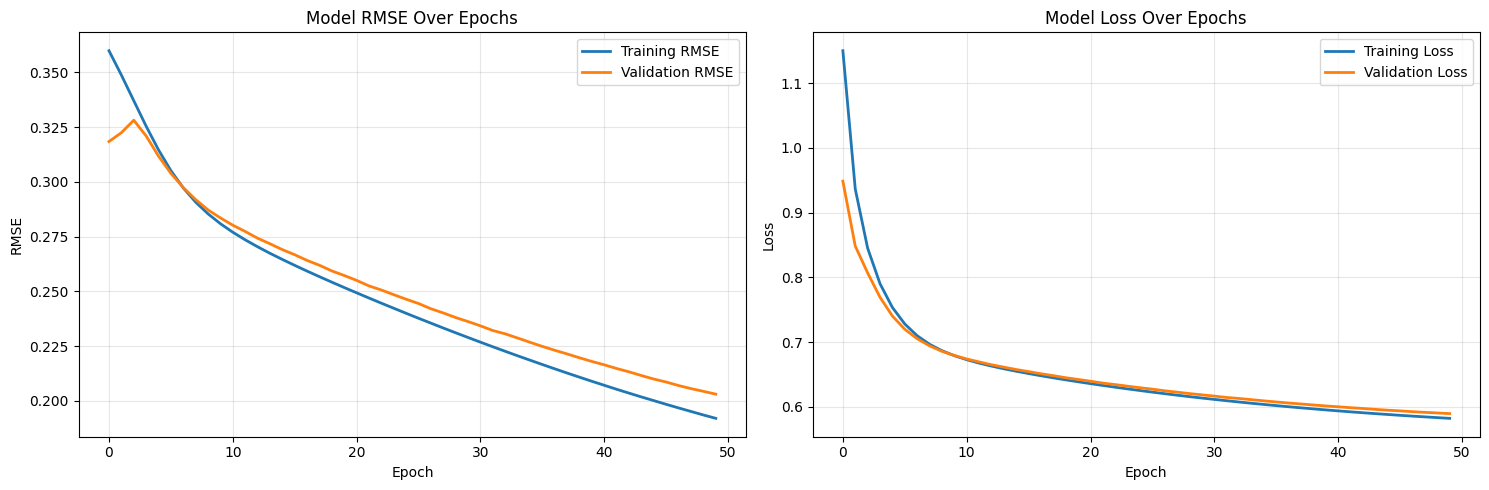


EVALUASI MODEL

📊 METRIK AKHIR:
   Training RMSE: 0.1920
   Validation RMSE: 0.2031
   Gap (Val - Train): 0.0110

🎯 STATUS OVERFITTING:
   ✅ EXCELLENT: Model memiliki generalisasi sangat baik

📈 ANALISIS PREDIKSI:
   Min prediction: 0.2128
   Max prediction: 0.8939
   Mean prediction: 0.6457
   Std prediction: 0.0803

--- Hasil Akhir Metrik Model Collaborative Filtering ---
Loss Training Terakhir: 0.5823
RMSE Training Terakhir: 0.1920
------------------------------
Loss Validasi Terakhir: 0.5896
RMSE Validasi Terakhir: 0.2031

--- Interpretasi ---
Model memiliki rata-rata kesalahan prediksi rating sebesar 0.2031 pada skala rating yang telah dinormalisasi [0, 1].


In [19]:
def comprehensive_evaluation(model, history, x_val, y_val):
    
    # 1. Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot RMSE
    ax1.plot(history.history['root_mean_squared_error'], label='Training RMSE', linewidth=2)
    ax1.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2)
    ax1.set_title('Model RMSE Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('RMSE')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Analisis detail
    train_rmse = history.history['root_mean_squared_error'][-1]
    val_rmse = history.history['val_root_mean_squared_error'][-1]
    gap = val_rmse - train_rmse
    
    print(f"\n{'='*50}")
    print(f"EVALUASI MODEL")
    print(f"{'='*50}")
    
    print(f"\n📊 METRIK AKHIR:")
    print(f"   Training RMSE: {train_rmse:.4f}")
    print(f"   Validation RMSE: {val_rmse:.4f}")
    print(f"   Gap (Val - Train): {gap:.4f}")
    
    print(f"\n🎯 STATUS OVERFITTING:")
    if gap <= 0.015:
        print("   ✅ EXCELLENT: Model memiliki generalisasi sangat baik")
        status = "EXCELLENT"
    elif gap <= 0.025:
        print("   ✅ GOOD: Model memiliki generalisasi baik")
        status = "GOOD"
    elif gap <= 0.035:
        print("   ⚡ MODERATE: Model sedikit overfitting tapi masih acceptable")
        status = "MODERATE"
    else:
        print("   ⚠️  POOR: Model mengalami overfitting signifikan")
        status = "POOR"
    
    # 3. Prediksi pada validation set
    val_predictions = model.predict(x_val, verbose=0)
    
    print(f"\n📈 ANALISIS PREDIKSI:")
    print(f"   Min prediction: {val_predictions.min():.4f}")
    print(f"   Max prediction: {val_predictions.max():.4f}")
    print(f"   Mean prediction: {val_predictions.mean():.4f}")
    print(f"   Std prediction: {val_predictions.std():.4f}")
    
    return status, gap

# Jalankan evaluasi
evaluation_status, final_gap = comprehensive_evaluation(model, history, x_val, y_val)
    
# Mengambil hasil dari epoch terakhir
final_loss = history.history['loss'][-1]
final_rmse = history.history['root_mean_squared_error'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_rmse = history.history['val_root_mean_squared_error'][-1]

print("\n--- Hasil Akhir Metrik Model Collaborative Filtering ---")
print(f"Loss Training Terakhir: {final_loss:.4f}")
print(f"RMSE Training Terakhir: {final_rmse:.4f}")
print("-" * 30)
print(f"Loss Validasi Terakhir: {final_val_loss:.4f}")
print(f"RMSE Validasi Terakhir: {final_val_rmse:.4f}")

# Memberikan interpretasi sederhana
print("\n--- Interpretasi ---")
print(f"Model memiliki rata-rata kesalahan prediksi rating sebesar {final_val_rmse:.4f} pada skala rating yang telah dinormalisasi [0, 1].")

## Generating Recommendations from Collaborative Model

In [21]:
# Generating Recommendations from Collaborative Model

def get_collab_recommendations(user_id_sample):
    books_read_by_user = df_collab[df_collab['User-ID'] == user_id_sample]
    books_not_read = books[~books['ISBN'].isin(books_read_by_user['ISBN'].values)]['ISBN']
    
    books_not_read_encoded_keys = set(isbn_to_isbn_encoded.keys())
    books_not_read = list(set(books_not_read).intersection(books_not_read_encoded_keys))
    
    if not books_not_read:
        print(f"Tidak dapat menemukan buku baru untuk direkomendasikan kepada User {user_id_sample}.")
        return

    books_not_read_encoded = [[isbn_to_isbn_encoded.get(x)] for x in books_not_read]
    user_encoder = user_to_user_encoded.get(user_id_sample)
    
    user_book_array = np.hstack(([[user_encoder]] * len(books_not_read_encoded), books_not_read_encoded))
    predicted_ratings = model.predict(user_book_array, verbose=0).flatten()
    
    top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
    recommended_isbn_ids = [isbn_encoded_to_isbn.get(books_not_read_encoded[x][0]) for x in top_ratings_indices]
    
    print("=" * 40)
    print(f"Menampilkan rekomendasi untuk User ID: {user_id_sample}")
    print("=" * 40)
    
    print("\nBuku yang pernah diberi rating tinggi oleh user ini:")
    top_books_user = books_read_by_user.sort_values(by='Book-Rating', ascending=False).head(5)
    
    # 1. Lakukan merge dan simpan ke variabel baru
    merged_df = pd.merge(top_books_user, books, on='ISBN')

    # 2. TAMBAHKAN BARIS INI untuk melihat nama kolom yang sebenarnya
    print("Nama kolom yang tersedia setelah merge:", merged_df.columns.tolist())

    # 3. Baris yang menyebabkan error (sekarang gunakan variabel merged_df)
    top_books_df = merged_df[['Book-Title', 'Book-Rating']]
    
    if not top_books_df.empty:
        display(top_books_df)
    else:
        print("User ini belum memberikan rating tinggi pada buku manapun.")

    print("\nTop 10 Rekomendasi Buku:")
    recommended_books = books[books['ISBN'].isin(recommended_isbn_ids)][['Book-Title', 'Book-Author']]
    display(recommended_books)


# --- Widget Interaktif ---
user_ids_list_collab = df_collab['User-ID'].unique().tolist()
user_ids_list_collab.sort()

@interact(user_id=widgets.Dropdown(options=user_ids_list_collab, description='Pilih User ID:'))
def interactive_collab_recommendations(user_id):
    get_collab_recommendations(user_id)

interactive(children=(Dropdown(description='Pilih User ID:', options=(8, 99, 242, 243, 254, 383, 388, 408, 424…